In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re,string
import itertools 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings("ignore")

In [2]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [3]:
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

In [4]:
df_train.head()

,Unnamed: 0,promptId,uniqueId,essay,evaluator_rating
0,0,1,1_323,"At present age, our education system is not go...",3.0
1,1,1,1_238,I am agree the tightly defined curriculum of o...,4.0
2,2,1,1_212,I strongly agree with the statement that tight...,2.0
3,3,1,1_117,Our education system is nice quitely but i dis...,2.0
4,4,1,1_229,i am totally agree with the statement that tig...,3.0


In [5]:
df_test.head()

,Unnamed: 0,promptId,uniqueId,essay
0,0,1,1_315,Curriculum has been adopted in many schools. T...
1,1,1,1_214,"I strongly agree with the statement , The tig..."
2,2,1,1_196,Imagination and creativity is the most importa...
3,3,1,1_178,In our eduction system leaves no room for imag...
4,4,1,1_201,"I will agree at some what extend, because if w..."


In [6]:
df_train.drop(["Unnamed: 0","uniqueId","promptId"],axis=1,inplace=True)
df_test.drop(["Unnamed: 0","uniqueId","promptId"],axis=1,inplace=True)

In [7]:
df_train.head()

,essay,evaluator_rating
0,"At present age, our education system is not go...",3.0
1,I am agree the tightly defined curriculum of o...,4.0
2,I strongly agree with the statement that tight...,2.0
3,Our education system is nice quitely but i dis...,2.0
4,i am totally agree with the statement that tig...,3.0


In [8]:
print(df_train.shape)
print(df_test.shape)

(1240, 2)
(305, 1)


In [9]:
df_train.isna().sum()

essay               0
evaluator_rating    0
dtype: int64

### We can see there is no null values so its good to go ahead

In [10]:
df_test.isna().sum()

essay    0
dtype: int64

### We can see there is no null values in test also

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1240 entries, 0 to 1239
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   essay             1240 non-null   object 
 1   evaluator_rating  1240 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.5+ KB


In [12]:
df_train.describe()


,evaluator_rating
count,1240.000000
mean,2.684274
std,1.082603
min,0.000000
25%,2.000000
50%,3.000000
75%,3.500000
max,5.000000


#### As we can see max score is 5 and 75% student score is under 3.5 and 25% under 2

In [13]:
print(df_train['evaluator_rating'].max())
print(df_train['evaluator_rating'].min())

5.0
0.0


In [14]:
print(df_train.groupby('evaluator_rating').size())

evaluator_rating
0.0     96
0.5      6
1.0     30
1.5     53
2.0    130
2.5    223
3.0    283
3.5    288
4.0    101
4.5     25
5.0      5
dtype: int64


<AxesSubplot:ylabel='evaluator_rating'>

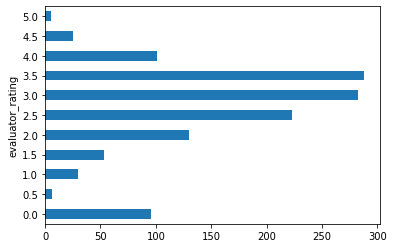

In [15]:
df_train.groupby('evaluator_rating').size().plot.barh()

### No of student scoring 3.5 is 288 and maximum marks is only obtained by 5 student

# Preprocessing

Almost every nlp task require to be preprocesses before training model. Here we are processing our data by replacing apostrrophes with standard meaning, lowering text removing stop words and finally lemmatization( I am doing this because in future If I do spell checker it will give benefit) 

In [16]:
stop_words = set(stopwords.words('english'))

def cleanData(text, lowercase = False, remove_stops = False, stemming = False, lemmatization = False):
    txt = str(text)
    # Replace apostrophes with standard lexicons
    txt = txt.replace("isn't", "is not")
    txt = txt.replace("aren't", "are not")
    txt = txt.replace("ain't", "am not")
    txt = txt.replace("won't", "will not")
    txt = txt.replace("didn't", "did not")
    txt = txt.replace("shan't", "shall not")
    txt = txt.replace("haven't", "have not")
    txt = txt.replace("hadn't", "had not")
    txt = txt.replace("hasn't", "has not")
    txt = txt.replace("don't", "do not")
    txt = txt.replace("wasn't", "was not")
    txt = txt.replace("weren't", "were not")
    txt = txt.replace("doesn't", "does not")
    txt = txt.replace("'s", " is")
    txt = txt.replace("'re", " are")
    txt = txt.replace("'m", " am")
    txt = txt.replace("'d", " would")
    txt = txt.replace("'ll", " will")

    # More cleaning
    txt = re.sub(r"alot", "a lot", txt)
    txt = re.sub(r"what's", "what", txt)
    txt = re.sub(r"What's", "what", txt)
    
    
    # Remove urls and emails
    txt = re.sub(r'^https?:\/\/.*[\r\n]*', ' ', txt, flags=re.MULTILINE)
    txt = re.sub(r'[\w\.-]+@[\w\.-]+', ' ', txt, flags=re.MULTILINE)
    
    # Remove punctuation from text
    txt = ''.join([c for c in text if c not in punctuation])
    
    # Remove all symbols
    txt = re.sub(r'[^A-Za-z\s]',r' ',txt)
    txt = re.sub(r'\n',r' ',txt)
    
    if lowercase:
        txt = " ".join([w.lower() for w in txt.split()])
        
    if remove_stops:
        txt = " ".join([w for w in txt.split() if w not in stop_words])
        
    if stemming:
        st = PorterStemmer()
        txt = " ".join([st.stem(w) for w in txt.split()])
    
    if lemmatization:
        wordnet_lemmatizer = WordNetLemmatizer()
        txt = " ".join([wordnet_lemmatizer.lemmatize(w, pos='v') for w in txt.split()])

    return txt

In [17]:
df_train['essay'] = df_train['essay'].apply(lambda x: cleanData(x, lowercase=True, remove_stops=True, stemming=False, lemmatization = True))

In [18]:
df_test['essay'] = df_test['essay'].apply(lambda x: cleanData(x, lowercase=True, remove_stops=True, stemming=False, lemmatization = True))

In [19]:
df_test['essay'].head()

0    curriculum adopt many school curriculum great ...
1    strongly agree statement tightly define curric...
2    imagination creativity important thing develop...
3    eduction system leave room imagination creativ...
4    agree extend think regular basic university mu...
Name: essay, dtype: object

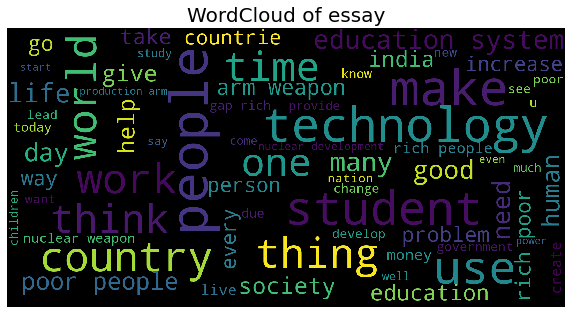

In [20]:
wc= WordCloud(width=1600,height=800, margin=0,max_words=500, 
max_font_size=150, min_font_size=30,).generate(" ".join(df_train['essay']))
plt.figure(figsize=(10, 16))
plt.imshow(wc, interpolation="nearest")
plt.title('WordCloud of essay', fontsize = 20)
plt.axis("off")
plt.show()

## Model
Here we define a 1-Layer LSTM Model and Embedding.
Activation fuction used--> Relu

In [21]:
from tensorflow.keras.layers import Embedding,Dropout,Bidirectional,LSTM,Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot

In [22]:
#vocab size
voc_size=6000

In [23]:
onehot_repr_train=[one_hot(words,voc_size)for words in df_train['essay']] 
onehot_repr_test=[one_hot(words,voc_size)for words in df_test['essay']] 

One-Hot Encoding. Each words are going to take a particular index for eg. Let say a text="rishabh is a good boy. rishabh is 
hard working boy". so when we do one-hot it will transform as [[23, 24,5,45,42],[23, 24,34,23,42]]. Here 23 indicates "rishabh" and 24 indicates "is".
#### Note- This index value can be change if we give different vocab size.

In [24]:
res = df_train['essay'].str.split().str.len().max()
print("The maximum length in words are : " +  str(res)) 

The maximum length in words are : 284


In [25]:
#Padding given values so every sentence has same dimension
sent_length=285
oneHotDoc=pad_sequences(onehot_repr_train,padding='pre',maxlen=sent_length)
print(oneHotDoc)

[[   0    0    0 ... 5961 4111 1818]
 [   0    0    0 ... 2515 5870 2292]
 [   0    0    0 ... 4641  374 3969]
 ...
 [   0    0    0 ... 1498 5677  905]
 [   0    0    0 ... 4946 3995 4600]
 [   0 3098 1851 ... 4709 5449 3546]]


In [26]:
def myModel():
    embedding_vector_features=200
    model = Sequential()
    model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
    model.add(Bidirectional(LSTM(100, recurrent_dropout=0.4)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()
    return model

In [27]:
X_final=np.array(oneHotDoc)
y_final=np.array(df_train['evaluator_rating'])
X_final

array([[   0,    0,    0, ..., 5961, 4111, 1818],
       [   0,    0,    0, ..., 2515, 5870, 2292],
       [   0,    0,    0, ..., 4641,  374, 3969],
       ...,
       [   0,    0,    0, ..., 1498, 5677,  905],
       [   0,    0,    0, ..., 4946, 3995, 4600],
       [   0, 3098, 1851, ..., 4709, 5449, 3546]])

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [29]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(830, 285)
(830,)
(410, 285)
(410,)


In [30]:
lstm_model = myModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 285, 200)          1200000   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               240800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 1,441,001
Trainable params: 1,441,001
Non-trainable params: 0
_________________________________________________________________


In [31]:
lstm_model.fit(X_train, y_train, batch_size=64, epochs=10)

Epoch 1/10
13/13 [==============================] - 32s 2s/step - loss: 2.6751 - mae: 1.2764
Epoch 2/10
13/13 [==============================] - 27s 2s/step - loss: 1.3965 - mae: 0.9152
Epoch 3/10
13/13 [==============================] - 24s 2s/step - loss: 1.1391 - mae: 0.8205
Epoch 4/10
13/13 [==============================] - 28s 2s/step - loss: 1.2381 - mae: 0.8745
Epoch 5/10
13/13 [==============================] - 26s 2s/step - loss: 0.6710 - mae: 0.6446
Epoch 6/10
13/13 [==============================] - 28s 2s/step - loss: 0.5812 - mae: 0.6087
Epoch 7/10
13/13 [==============================] - 26s 2s/step - loss: 0.3797 - mae: 0.4869
Epoch 8/10
13/13 [==============================] - 27s 2s/step - loss: 0.3465 - mae: 0.4516
Epoch 9/10
13/13 [==============================] - 26s 2s/step - loss: 0.2918 - mae: 0.4141
Epoch 10/10
13/13 [==============================] - 26s 2s/step - loss: 0.2966 - mae: 0.4326


In [32]:
y_pred = lstm_model.predict(X_test)

In [33]:
y_pred

array([[2.4084723 ],
       [3.4325888 ],
       [2.3818944 ],
       [3.2036848 ],
       [3.1177657 ],
       [1.6744512 ],
       [1.5749406 ],
       [3.04763   ],
       [2.5734382 ],
       [2.485934  ],
       [1.7771107 ],
       [2.3573568 ],
       [2.6890695 ],
       [2.581239  ],
       [3.0991375 ],
       [2.5746996 ],
       [2.3776584 ],
       [2.3896387 ],
       [2.2221115 ],
       [2.8709166 ],
       [1.8870579 ],
       [2.7145147 ],
       [1.6513342 ],
       [2.3010657 ],
       [2.3937018 ],
       [0.8853    ],
       [2.602664  ],
       [2.962452  ],
       [3.4071958 ],
       [2.0819695 ],
       [2.3427103 ],
       [3.1255748 ],
       [3.3348157 ],
       [2.9244993 ],
       [1.8908724 ],
       [3.0870035 ],
       [3.3739712 ],
       [2.1507814 ],
       [2.354299  ],
       [1.3793672 ],
       [2.872063  ],
       [3.410589  ],
       [2.0129995 ],
       [2.8881476 ],
       [3.004908  ],
       [3.2413092 ],
       [2.870262  ],
       [3.182

In [34]:
from sklearn.metrics import mean_squared_error

In [35]:
mean_squared_error(y_pred,y_test)
#epoch =50 we get mse 1.3529 vocab_size is 2000
#epoch=70 we get mse 1.3514 vocab_size is 2000
#epoch =50 we get mse 1.4 vocab_size is 2000
#epoch =70 Bidirectional LSTM mse 1.19 voacb_size is 8000 Vector dimension is 200
#epoch =100 Bidirectional LSTM mse 1.17 voacb_size is 8000 Vector dimension is 200
#epoch =1500 Bidirectional LSTM mse 1.10 voacb_size is 8000 Vector dimension is 200

1.1443372380341497

In [36]:
sent_length=285
embedded_docs_test=pad_sequences(onehot_repr_test,padding='pre',maxlen=sent_length)

In [37]:
X_new=np.array(embedded_docs_test)

In [38]:
X_new

array([[   0,    0,    0, ..., 2678, 2455, 5626],
       [   0,    0,    0, ..., 4438, 5200, 3601],
       [   0,    0,    0, ..., 4496, 1737, 4745],
       ...,
       [   0,    0,    0, ..., 2629, 4340, 1518],
       [   0,    0,    0, ..., 3570, 5677, 4419],
       [   0,    0,    0, ..., 3570,  168, 3314]])

In [39]:
y_pred_new = lstm_model.predict(X_new)

In [40]:
y_pred_new.shape

(305, 1)

In [41]:
yete=y_pred_new.flatten().round(1)
yete

array([2.5, 3.2, 2.3, 3.4, 2.4, 3. , 2.5, 1.7, 1.6, 2.8, 2.1, 2.8, 2.4,
       2.9, 1.8, 2.5, 2.3, 2.4, 3.1, 1.6, 2.8, 2.1, 2.4, 2.8, 1.5, 2.6,
       3.2, 2.8, 1.7, 1.3, 3. , 2.8, 2.4, 3. , 2.5, 2.7, 2.3, 2.4, 3.5,
       1.2, 3. , 1.9, 3.4, 2.6, 2.2, 3. , 2.9, 3. , 3.1, 2.6, 2. , 2.7,
       3. , 2.5, 2.7, 1.5, 2.2, 2. , 2. , 2.8, 2.7, 2.7, 2.8, 2.9, 2.4,
       2.6, 2.3, 0.8, 2.9, 2. , 2.3, 2.8, 2.7, 2.6, 2. , 2.7, 1.8, 2.4,
       2.4, 2.8, 3. , 2.9, 2. , 3.2, 2.3, 2.9, 2. , 2. , 1.9, 1.7, 2.4,
       2.5, 1.3, 3. , 1.4, 1.6, 2.5, 2.6, 3. , 1.6, 2.8, 3. , 2.1, 2. ,
       2.4, 3.3, 2.3, 2.1, 1.3, 2.5, 3.1, 2.3, 2.1, 1. , 2.4, 2.6, 2.1,
       2.5, 3.3, 2.8, 2.4, 2.7, 2. , 2.8, 2.6, 2.1, 2.3, 2.4, 2.8, 2.4,
       3.9, 2.9, 1.9, 3.3, 2.1, 2.1, 3.2, 1.6, 1.7, 3.3, 0. , 1.4, 2.2,
       2.1, 2.9, 3. , 2. , 2.9, 3. , 2. , 3. , 2.8, 2.9, 1.9, 3.7, 1.6,
       3.3, 1.5, 2.9, 2.2, 3.2, 1.6, 3. , 1.5, 2.7, 3. , 3.4, 3. , 2.7,
       2.4, 2.7, 2.9, 3.3, 2.9, 3.2, 3.2, 2.2, 2.7, 2.7, 3.3, 3.

In [42]:
df_test_new=pd.read_csv('test.csv')

In [43]:
df_test_new.drop(["Unnamed: 0"],axis=1,inplace=True)

In [44]:
df_test_new.head()

,promptId,uniqueId,essay
0,1,1_315,Curriculum has been adopted in many schools. T...
1,1,1_214,"I strongly agree with the statement , The tig..."
2,1,1_196,Imagination and creativity is the most importa...
3,1,1_178,In our eduction system leaves no room for imag...
4,1,1_201,"I will agree at some what extend, because if w..."


In [45]:
df_data=pd.DataFrame({'predicted_score':yete})

In [46]:
df_data.head()

,predicted_score
0,2.5
1,3.2
2,2.3
3,3.4
4,2.4


In [47]:
new=pd.concat([df_test_new,df_data],axis=1, join='inner')

In [48]:
new.head()

,promptId,uniqueId,essay,predicted_score
0,1,1_315,Curriculum has been adopted in many schools. T...,2.5
1,1,1_214,"I strongly agree with the statement , The tig...",3.2
2,1,1_196,Imagination and creativity is the most importa...,2.3
3,1,1_178,In our eduction system leaves no room for imag...,3.4
4,1,1_201,"I will agree at some what extend, because if w...",2.4


In [49]:
new.to_csv('test.csv',index=False)